# Race-Memory Project Analysis

### Load libraries, custom functions, and metadata

In [1]:
import math
import numpy as np
import pandas as pd
from datetime import datetime 
import matplotlib.pyplot as plt
import json
import scipy.stats as sp
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from ast import literal_eval
from IPython.display import Markdown as md
import re, os
pd.options.mode.chained_assignment = None 
import warnings ; warnings.filterwarnings('ignore')
downloads_path = '/Users/chrisiyer/Downloads/'

In [2]:
###### import custom functions
import functions as fun
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [3]:
meta = fun.load_metadata() # load metadata just in case

### Load data

In [233]:
data_path = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/results/data/main/afc_across_unused/'
files = [i for i in os.listdir(data_path) if i.startswith('taskdata')]
df_list = [pd.read_csv(data_path + f) for f in files]
df = pd.concat(df_list)

In [234]:
# fill in tilt_difference and tilt_change
for i in range(len(df)):
    if 'retrieval' in df.trial_type.iloc[i]:
        if pd.isna(df.tilt_difference.iloc[i]) and not pd.isna(df.old_tiltLR.iloc[i]) and not pd.isna(df.old_original_tiltLR.iloc[i]):
            tilt = fun.get_tilt_change(df.old_original_tiltLR.iloc[i], df.old_tiltLR.iloc[i])
            df['tilt_difference'].iloc[i] = tilt['difference']
            df['tilt_change'].iloc[i] = tilt['change'] 
if df[df.trial_type == 'retrieval'].tilt_difference.isna().sum() != 0:
    print('tilt difference incomplete')
else: print('all good!')
if df[df.trial_type == 'retrieval'].tilt_change.isna().sum() != 0:
    print('tilt change incomplete')
else: print('all good!')

all good!
all good!


In [235]:
# add 'tilted' boolean column
df['tilted'] = (df['tilt_difference'] != 0) & ( (df['trial_type'] == 'retrieval') | (df['trial_type'] == 'retrieval_practice') )  
df.loc[(df['trial_type'] == 'retrieval') | (df['trial_type'] == 'retrieval_practice'), 
       'response'] = pd.to_numeric(df.loc[(df['trial_type'] == 'retrieval') | 
                                          (df['trial_type'] == 'retrieval_practice'), 
                                          'response'])

In [236]:
df['iteration'] = df['iteration'].replace(['sona_af3'],'sona_afc3') # typo in one iteration

In [237]:
df_noexcludes = df.copy()

### Subject Exclusions

In [238]:
# 1. PROLIFIC GLITCH (subjects who confirmed glitch) from 'prolific_afc_50_subjects'
# one of these participants got like 70% on the retrieval trials they did. So maybe scrap the whole iteration?
glitch_reported = [
    '5e68682ce3b2f71041fa03d2', 
    '610d170f7bb4e720cb85b6b2',
    '580bea98827ca10001db514e',
    '60ba71aa8f2ae12d3a595982'
]
prolific_glitch = [i for i in glitch_reported if i in df.subject_id.unique()]
df = df[~df.subject_id.isin(prolific_glitch)]
print(str(len(prolific_glitch)) + ' PROLIFIC IDS EXCLUDED:', '\n', prolific_glitch)

3 PROLIFIC IDS EXCLUDED: 
 ['5e68682ce3b2f71041fa03d2', '580bea98827ca10001db514e', '60ba71aa8f2ae12d3a595982']


In [239]:
# 2. UNFINISHED EXPERIMENT (there are many b/c df contains data from a glitchy run)
# This includes 9 subjects from a glitchy run in pilot_prolific_afc2, 11+ others from elsewhere
# This is computed based on if there is a 'summary' trial or not
df = fun.exclude_nofinish(df) 

12 EXPERIMENT IDS EXCLUDED:
 ['cqbz7lh19r6krarwzy7n', nan, 'o1qhbw4lrfpx8jk9vyxn', 'y9krtso6fmwtl2u13csl', 'e79drsrtw4392byd7eem', '184gl7o42b9bdl9e6xsm', 'xpyxc6uu5ea54nd1fu5p', '4mc72sfz921j7s6hgvkm', 'urxm6qqdbsataccvjjcm', 'socq4e5100dn03j66xdr', 'f4qdjdd8mr5gm6djqcn9', 'coar15q7qjjbfusnr6yb']
[111, 0, 86, 115, 83, 88, 91, 92, 94, 69, 87, 41]


In [240]:
# 4. SKIPPED - REPEATED INCORRECT PRACTICE TRIALS
# if they got max_wrong = 5 practice trials wrong in a row, excluded
# df = fun.exclude_practice(df, max_wrong = 5)

In [241]:
# 5. TIMEOUTS - subs who timed out on everything
df = fun.exclude_timeout(df)

2 EXPERIMENT IDS EXCLUDED:
 ['g51c2p98lpbc8zxstqra', 'akn81dwp3vhwnstj0wmb']


In [242]:
# 6. EXCLUDE SUBJECTS BY RETRIEVAL PERFORMANCE above chance? or what
df_raw = df.copy()
df = fun.exclude_chance_retrieval(df, alt = 'greater', p = 0.05, testing=False) # vs. 'two-sided' for t testb

61 EXPERIMENT IDS EXCLUDED:
 ['xwmb1haw97aqjvmasabg', '4snme6wmcvuu3cuhdvtm', 'ceq3ks1gmccbjy2yn8x2', 'seedpj7uldldxy6lf1c8', '2kpkofq47hdd2o17qbud', 'jeo5c1qlspbhvtmte7bs', 'xd3745hqtcx480gn7fxs', 'u4rpd5ts3tesscv4r7fr', 'uqqc4xamkzkkanb69nkg', '89mc33z85xn163derfww', '3qr26fcu26dtoq4nzrrg', 'w9thbftpvrvwen1dnzmb', '81hm045jcbclczucg0q7', 'wlfgh75mt7c5w9u1pomu', '2mfw79sej04sbtubrhe1', 'l2t0qug5at9vpx3ju1sp', 'dkk63zh1q3gh854m6dp9', 's2qs4xhu3p6tpk285kb7', 'cv6e11c2uks0f7zatw3d', 'l4ppshby9z8vnnxwuxsk', 'epndqmsa0uj1qh9jmbu9', '5hwp55q0sk25h6o10f93', 'l4zftyeh2moon0cj7aod', 'dt44jlujz2xe9mla3ldo', 'oahy6299w5nz5avma2l9', 'vou1tuxzzovgxjtw7acb', 'rmfll4tyvbhhkzeqe8ry', 'rr3h613dq01auhzqwk5w', '53gjcemhzdg46rufpo0r', '45zas584gtbef9mznenf', 'hgdn3jchvl76kthdexth', '1gnsb1xss8nrg5j30b7x', 'kx36wp0xsxear2wj66cx', 'hlvyy3d6grxj3j7uozur', '6msjz2xyp1wpamd2eln7', 'lsz7xxf8coenxr4uh39j', '2ljshm8ym4b4jgengaxy', 'yb9u220bz2thk3s3cfan', 'yod6feb8j8zytzwl17xm', '9wxgoxbfmz8cj8kjdvyb', 'agtu5brey

This step ^ loses 61 / 98 subjects, leaving only 37.

In [94]:
# 7. CHECK ITERATIONS
# 'pilot_prolific_afc', 'prolific_afc3', 'sona_afc3': these are the within-race AFC pairing iterations
# df = df[df.iteration.isin(['pilot_prolific_afc', 'prolific_afc3', 'sona_afc3'])]

### Remaining subject demographics

In [244]:
print('# of participants remaining:')
print(len(df.experiment_id.unique()))

print('No retrieval cutoff total subjects: ', len(df_raw.experiment_id.unique()))

# of participants remaining:
37
No retrieval cutoff total subjects:  98


In [245]:
# 6. SEPARATE DF with just white-identifying subjects
df_white = df[df.experiment_id.isin(
    df[df.race == "['White']"].experiment_id.unique()
)]

print(len(df.experiment_id.unique()))
print(len(df_white.experiment_id.unique()))

37
20


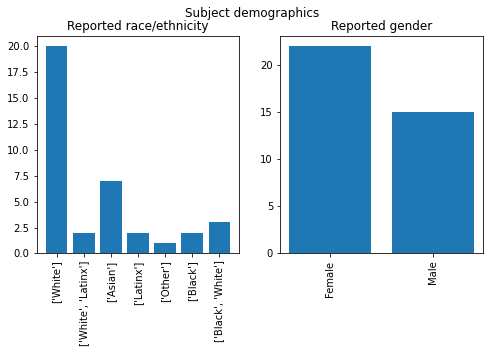

["['White']" "['White', 'Latinx']" "['Asian']" "['Latinx']" "['Other']"
 "['Black']" "['Black', 'White']"]
[20, 2, 7, 2, 1, 2, 3]
22 women, 15 men


In [108]:
fun.demographics_plot(df)

In [109]:
print('Age range: ' + str(df.age.min()) + " - " + str(df.age.max()))
print('Median age: ' + str(df.age.median()))

Age range: 18.0 - 63.0
Median age: 23.0


## Subject-Level

In [326]:
stats = fun.get_stats(df, only_correct_encoding = True, only_high_confidence = False)

In [328]:
stats_raw = fun.get_stats(df_raw, only_correct_encoding = True, only_high_confidence = False)

In [329]:
stats_orig = stats.copy()
stats = stats_raw

### ******MAIN SUMMARY******

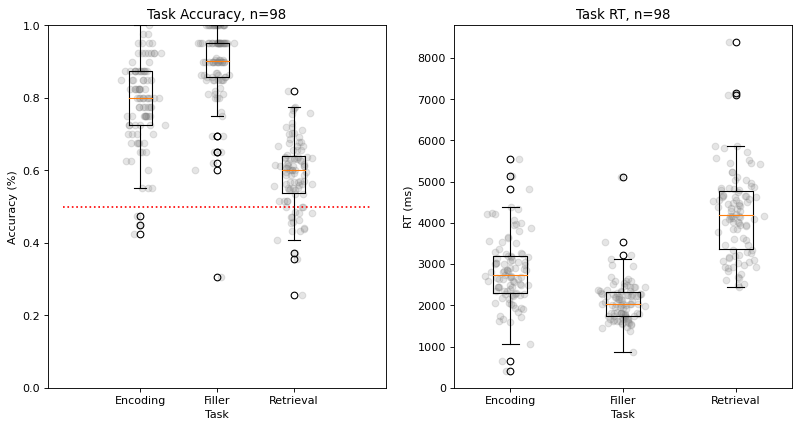

Population retrieval accuracy is significantly above chance:
Ttest_1sampResult(statistic=8.993042413836088, pvalue=2.0014716490180295e-14)


In [330]:
fun.summary_plot(stats)
print('Population retrieval accuracy is significantly above chance:')
print(sp.ttest_1samp(stats.ret_acc, popmean = 0.5))

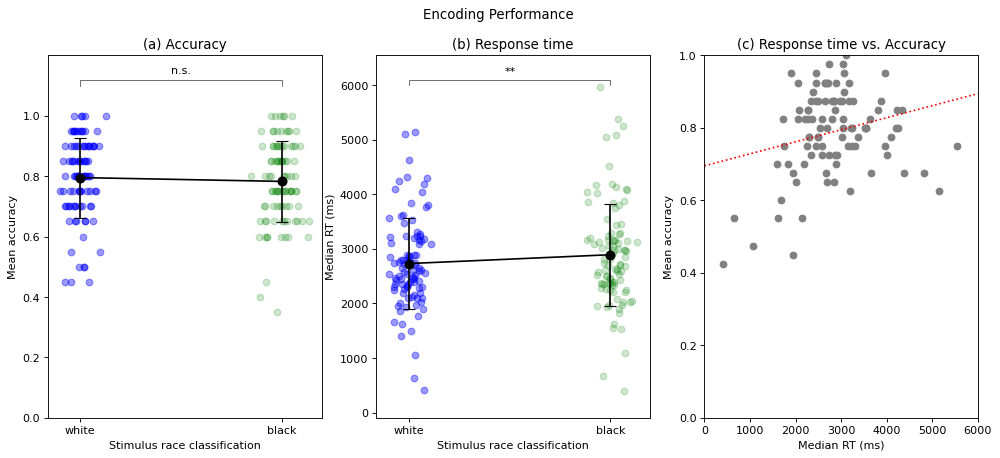

In [331]:
fun.encoding_plots(stats, save=False)

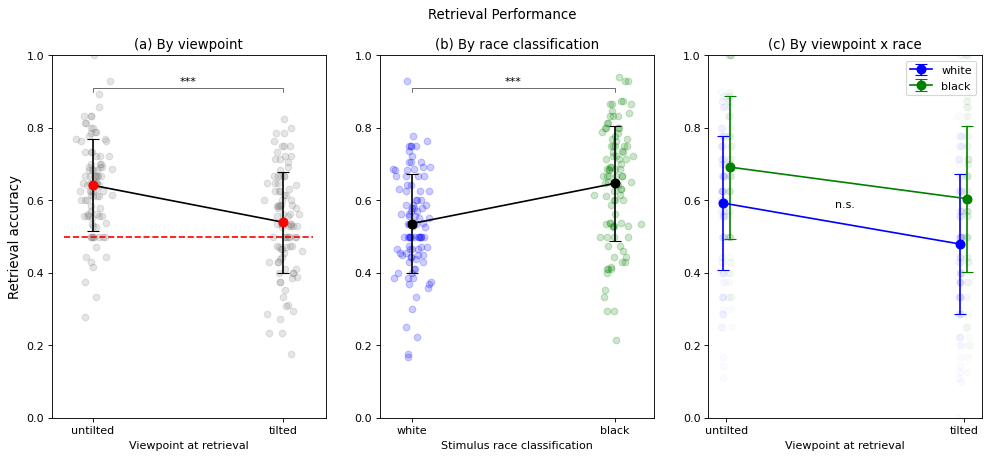

In [332]:
fun.retrieval_plots(stats, save=False)

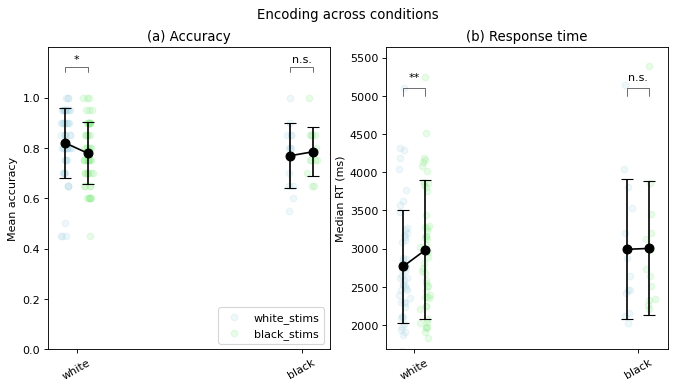

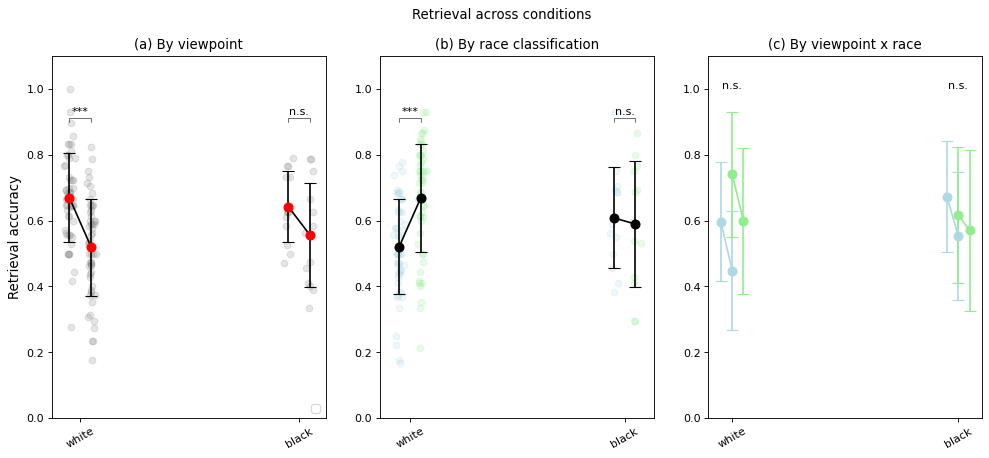

In [333]:
data_wb = {
    'white': stats[stats.race.str.contains('White')],
    'black': stats[stats.race.str.contains('Black')]
}
fun.compare_versions(data_wb)

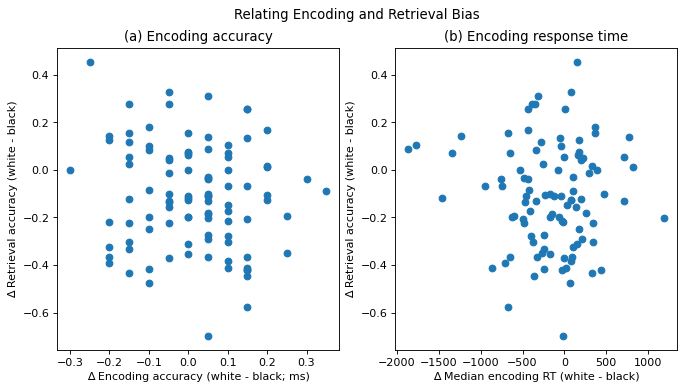

In [334]:
fun.encoding_delta_plot(stats, save = False)
#plt.scatter(stats.enc_rt_delta, stats.ret_acc_w_0-stats.ret_acc_b_0)

In [117]:
fun.results(stats)


--Encoding--
 - accuracy by race (Wilcoxon):
WilcoxonResult(statistic=159.0, pvalue=0.04869095066091862)
 - RT by race (Wilcoxon):
WilcoxonResult(statistic=185.0, pvalue=0.012009448533382025)
 - RT vs. accuracy (OLS):
LinregressResult(slope=-2.091320248047848e-05, intercept=0.8810362641342573, rvalue=-0.17831064430475838, pvalue=0.2910205946168341, stderr=1.9507112195627403e-05, intercept_stderr=0.0608764963938353)

--Retrieval--
 - accuracy by tilt (Wilcoxon):
WilcoxonResult(statistic=15.0, pvalue=3.8437972188690316e-07)
 - accuracy by race (Wilcoxon):
WilcoxonResult(statistic=109.0, pvalue=0.00043290120209328413)
 - dist by race (Wilcoxon):
WilcoxonResult(statistic=114.0, pvalue=0.0003396798954368158)
 - accuracy by tilt * race (OLS):
$\beta = -0.05$, $F(3, 144)$ = $-0.95, P = 0.344 $

--Encoding-Retrieval--
 - ∆enc_rt vs ∆ret_acc (OLS):
LinregressResult(slope=-9.554333104729562e-07, intercept=-0.1225008003997956, rvalue=-0.0022941699194807827, pvalue=0.9892480951776148, stderr=7.03

### MORE IN DEPTH

### 1. Encoding

Encoding performance by tilt metrics

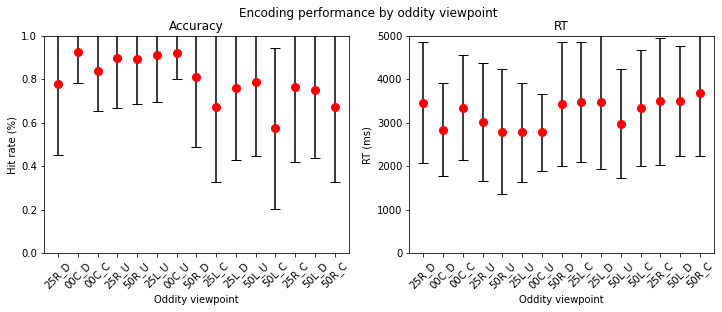

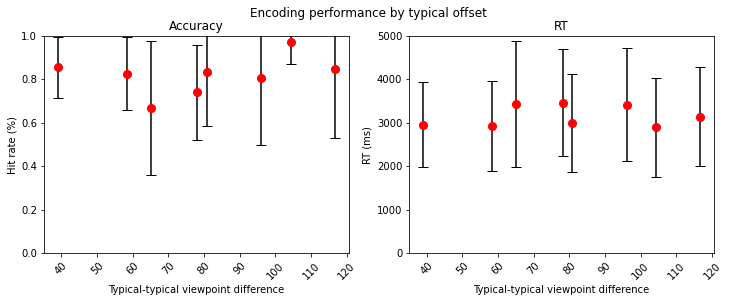

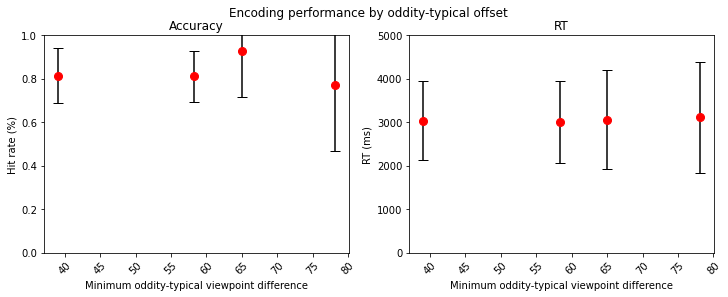

In [119]:
fun.encoding_view_plots(df)

### 2. Filler

accuracy and RT by category

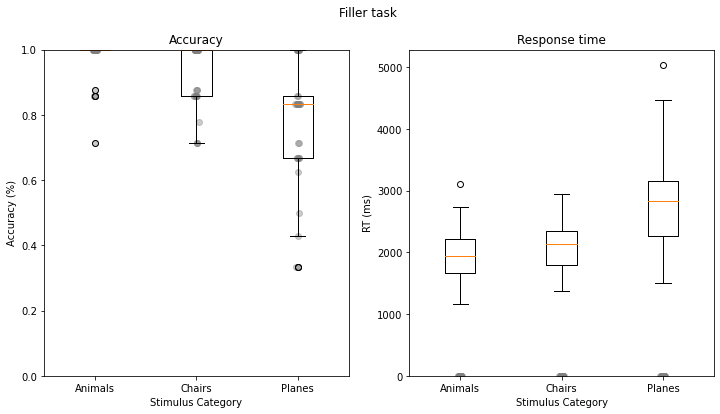

In [120]:
fun.filler_plot(stats)

encoding-retrieval delay vs. mean retrieval accuracy per subject

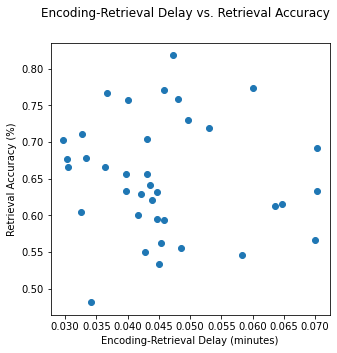

LinregressResult(slope=-0.008663276249821538, intercept=0.6754578658554015, rvalue=-0.0750155505777171, pvalue=0.6590225907407499, stderr=0.01946576288734746, intercept_stderr=0.05496086518162483)


In [121]:
fun.filler_delay_plot(stats[stats.enc_ret_delay/60 < 1]) # 2 outliers excluded, < 0.2 for 4 outliers excluded
print(sp.linregress(x=stats.enc_ret_delay, y=stats.ret_acc))

Filler performance predicted by encoding performance

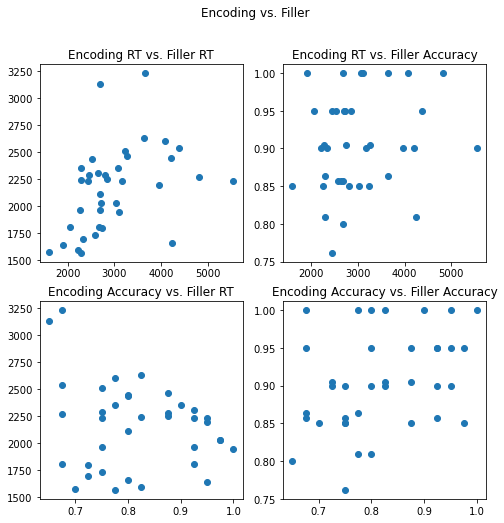

LinregressResult(slope=0.1864589757469582, intercept=1607.4441437535015, rvalue=0.4055876551564395, pvalue=0.012756558851466161, stderr=0.07102928147351689, intercept_stderr=221.66345044391085)
LinregressResult(slope=1.3957795361379465e-05, intercept=0.8633325701936385, rvalue=0.1848564214105687, pvalue=0.27337748472912793, stderr=1.2542906426022559e-05, intercept_stderr=0.03914306690577875)
LinregressResult(slope=-848.1984956888642, intercept=2861.329985323794, rvalue=-0.21639250011028777, pvalue=0.1983063967603839, stderr=646.8557305813282, intercept_stderr=533.2054785122772)
LinregressResult(slope=0.22968381829141324, intercept=0.7173043728423476, rvalue=0.3567725126183181, pvalue=0.03019116255319292, stderr=0.10165782320586338, intercept_stderr=0.08379690509703817)


In [122]:
fun.encoding_filler_plot(stats)
print(sp.linregress(x=stats.enc_rt, y=stats.fil_rt))
print(sp.linregress(x=stats.enc_rt, y=stats.fil_acc))
print(sp.linregress(x=stats.enc_acc, y=stats.fil_rt))
print(sp.linregress(x=stats.enc_acc, y=stats.fil_acc))

### 3. Retrieval

Distribution of slider responses

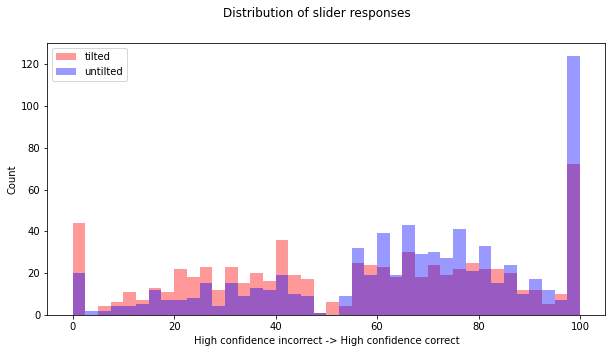

In [123]:
fun.slider_response_plot(df)

Confidence by tilt for hit trials

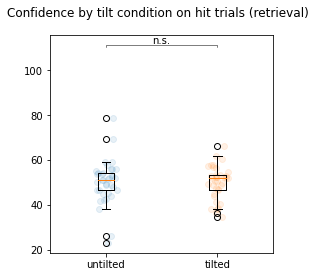

WilcoxonResult(statistic=303.0, pvalue=0.4643609407169079)


In [124]:
fun.hits_confidence_by_tilt_plot(df)

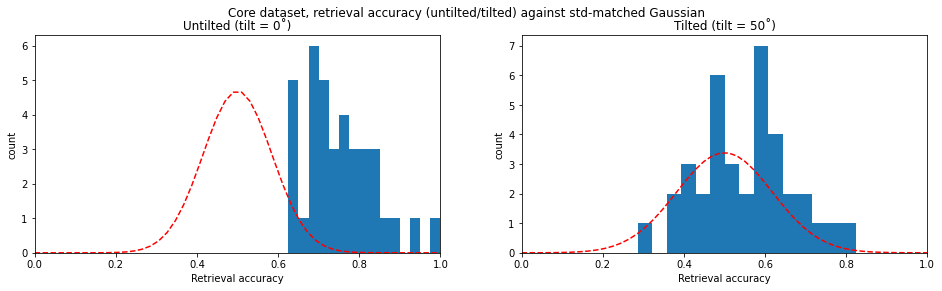

In [258]:
fun.tilt_chance_hist(stats)

retrieval accuracy black vs. white

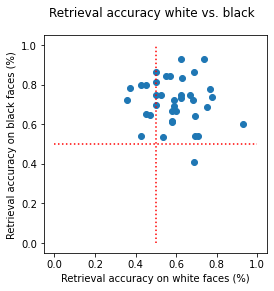

In [125]:
fun.retrieval_race_scatter_plot(stats)

Serial position at encoding vs. average retrieval accuracy (for recency/primacy effects?)

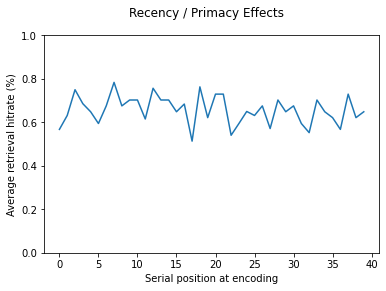

In [126]:
# serial position
fun.serial_position_plot(df)

Retrieval performance predicted by encoding performance

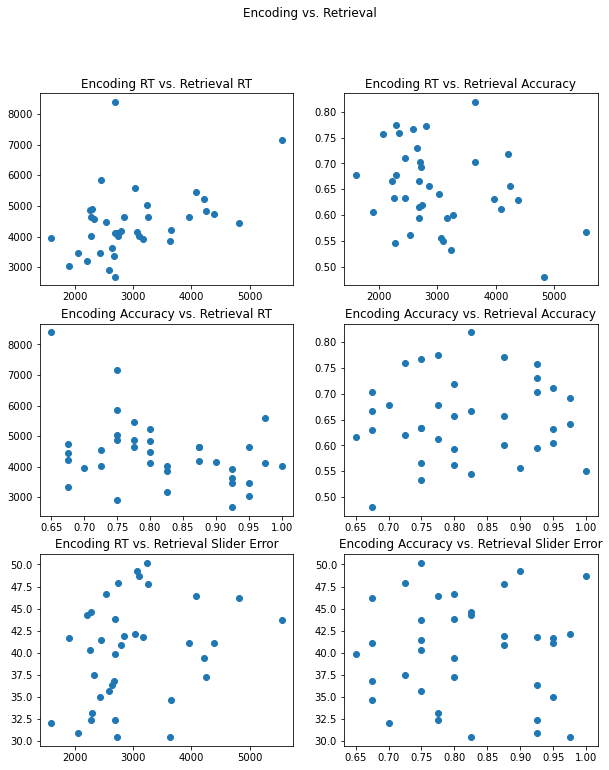

LinregressResult(slope=0.5160347693861608, intercept=2893.662846259056, rvalue=0.4044457426769134, pvalue=0.013034903767225754, stderr=0.19724128526652338, intercept_stderr=615.5374650449003)
None
LinregressResult(slope=-2.684051346439591e-05, intercept=0.7322863867108323, rvalue=-0.29504233891308773, pvalue=0.07626590382490044, stderr=1.4692508686696945e-05, intercept_stderr=0.045851402458360294)
None
LinregressResult(slope=-4002.5874151027465, intercept=7718.175243010583, rvalue=-0.367930171000778, pvalue=0.025061070173180995, stderr=1709.8416642313546, intercept_stderr=1409.4285628997477)
None
LinregressResult(slope=0.05401604473657217, intercept=0.607498030562993, rvalue=0.06964013042227976, pvalue=0.6821264764292216, stderr=0.1307896901899181, intercept_stderr=0.10781040662577811)
None
LinregressResult(slope=0.001871488601404776, intercept=34.56302480325775, rvalue=0.2801444238740394, pvalue=0.09307782545910277, stderr=0.0010839851998794918, intercept_stderr=3.3828288087780862)
No

In [127]:
fun.encoding_retrieval_plot(stats)
print(fun.linregna(x=stats.enc_rt, y=stats.ret_rt))
print(fun.linregna(x=stats.enc_rt, y=stats.ret_acc))
print(fun.linregna(x=stats.enc_acc, y=stats.ret_rt))
print(fun.linregna(x=stats.enc_acc, y=stats.ret_acc))
print(fun.linregna(x=stats.enc_rt, y=stats.ret_dist))
print(fun.linregna(x=stats.enc_acc, y=stats.ret_dist))

Retrieval accuracy by tilt shown at encoding

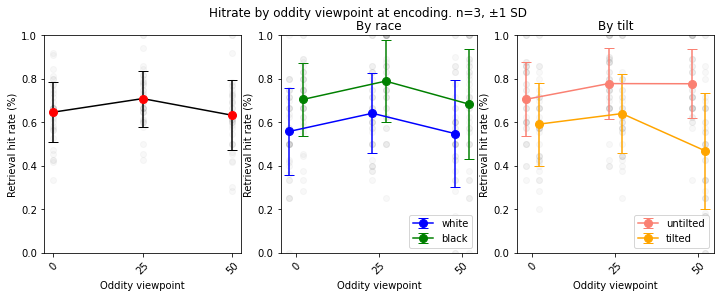

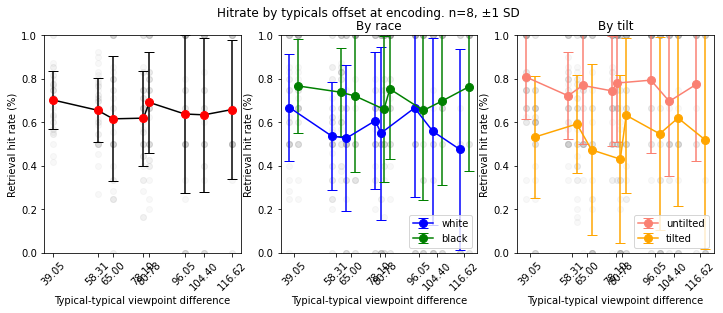

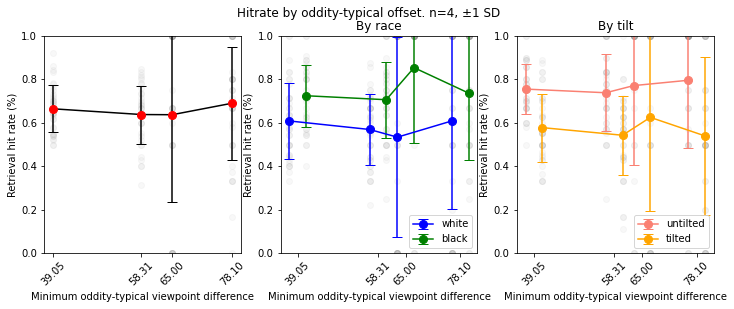

In [128]:
# 3 measures of encoding tilt on retrieval performance:
# 1. Oddity viewpoint (symmetrical)
# 2. Typical-typical offset
# 3. Oddity-typical offset (min)

fun.encoding_tilt_plots(df)

In [129]:
fun.show_model_parameters(smf.ols("accuracy ~ enc_tilt * ret_tilt", data = {
        'accuracy': np.concatenate([stats.ret_acc_0_enc_00C, 
                                    np.nanmean([stats.ret_acc_0_enc_25R, stats.ret_acc_0_enc_25L],axis=0), 
                                    np.nanmean([stats.ret_acc_0_enc_50R, stats.ret_acc_0_enc_50L],axis=0),
                                    stats.ret_acc_50_enc_00C, 
                                    np.nanmean([stats.ret_acc_50_enc_25R, stats.ret_acc_50_enc_25L],axis=0), 
                                    np.nanmean([stats.ret_acc_50_enc_50R, stats.ret_acc_50_enc_50L],axis=0),
                                    ]), 
    
        'ret_tilt': np.concatenate([np.repeat(0, 3*len(stats)), np.repeat(1, 3*len(stats))]),
        'enc_tilt': np.concatenate([np.repeat(0, len(stats)), np.repeat(1, len(stats)), np.repeat(2, len(stats)), 
                                    np.repeat(0, len(stats)), np.repeat(1, len(stats)), np.repeat(2, len(stats))])
        }))

$\beta = -0.11$, $F(3, 218)$ = $-2.85, P = 0.005 $

### Key retrieval analyses


**1. Retrieval bias predicted by encoding bias**

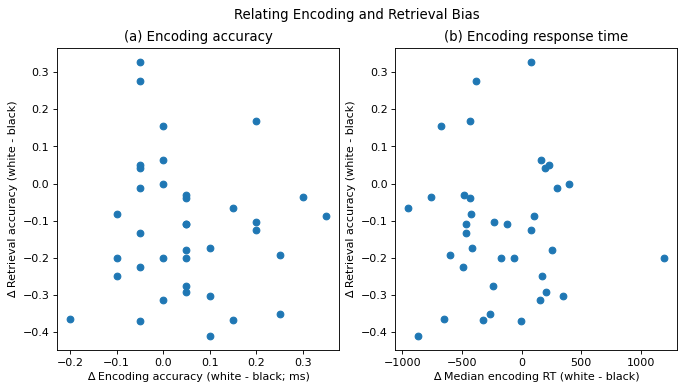

LinregressResult(slope=-9.554333104729562e-07, intercept=-0.1225008003997956, rvalue=-0.0022941699194807827, pvalue=0.9892480951776148, stderr=7.039464649962894e-05, intercept_stderr=0.032092140570462654)
None
LinregressResult(slope=-0.09074482449095458, intercept=-0.11780672608845984, rvalue=-0.06246264030521561, pvalue=0.7134223301374296, stderr=0.24508607128714668, intercept_stderr=0.03229641627378157)
None
LinregressResult(slope=0.00684709203289045, intercept=8.203892464818814, rvalue=0.2878789700459917, pvalue=0.08402654476817639, stderr=0.003850140998479427, intercept_stderr=1.7552366874937642)
None
LinregressResult(slope=-1.9710448607120414, intercept=7.17850380348252, rvalue=-0.0237560129957828, pvalue=0.8890060292981035, stderr=14.020591992825054, intercept_stderr=1.847574907162315)
None


In [130]:
fun.encoding_delta_plot(stats, save=False, slider=False)
# fun.encoding_delta_plot(stats, slider=True)
print(fun.linregna(x=stats.enc_rt_delta, y=stats.ret_acc_delta))
print(fun.linregna(x=stats.enc_acc_delta, y=stats.ret_acc_delta))
print(fun.linregna(x=stats.enc_rt_delta, y=stats.ret_dist_delta))
print(fun.linregna(x=stats.enc_acc_delta, y=stats.ret_dist_delta))

In [131]:
smf.mixedlm("ret_acc_delta ~ enc_rt_delta", data = {
    "ret_acc_delta": stats.ret_acc_delta,
    "enc_rt_delta": stats.enc_rt_delta
    }, groups = stats['experiment_id'],
            #re_formula = "~enc_rt_delta"
           ).fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: ret_acc_delta
No. Observations: 37      Method:             REML         
No. Groups:       37      Scale:              0.0166       
Min. group size:  1       Log-Likelihood:     0.2823       
Max. group size:  1       Converged:          Yes          
Mean group size:  1.0                                      
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept       -0.123    0.006 -21.249 0.000 -0.134 -0.111
enc_rt_delta    -0.000    0.000  -0.016 0.987 -0.000  0.000
Group Var        0.017                                     
===========================================================

"""

are residuals greater than 0? of course they are

**2. Retrieval accuracy by tilt and race**

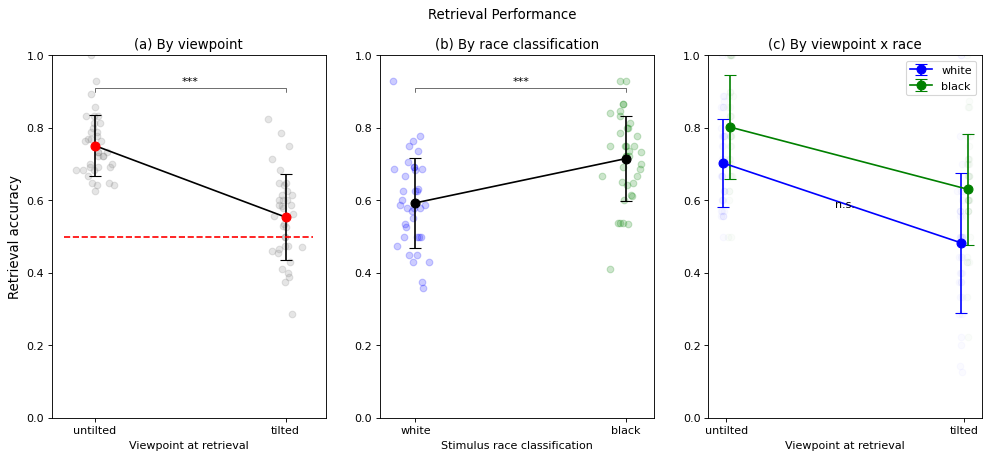

In [132]:
fun.retrieval_plots(stats, save=False)

**3. Retrieval accuracy by encoding median RT split**

In [133]:
stats_enc_split = fun.get_encoding_split_stats(df, only_correct_encoding = True, only_high_confidence = False)

In [134]:
stats_enc_split

,experiment_id,enc_acc_high,enc_acc_low,enc_acc_delta,enc_rt_high,enc_rt_low,enc_rt_delta,ret_acc_high,ret_acc_low,ret_acc_delta,...,ret_acc_low_0,ret_acc_high_50,ret_acc_low_50,ret_dist_high,ret_dist_low,ret_dist_delta,ret_dist_high_0,ret_dist_low_0,ret_dist_high_50,ret_dist_low_50
0,45lnjyfmazvdv1660be6,0.55,0.85,-0.30,1726.5,1348.0,378.5,0.636364,0.705882,-0.069519,...,0.666667,0.666667,0.750000,36.363636,29.294118,7.069519,40.000000,33.111111,33.333333,25.000000
1,fo1wf4v46ynrg825tuzd,0.60,0.90,-0.30,6959.0,3991.5,2967.5,0.416667,0.666667,-0.250000,...,0.700000,0.333333,0.625000,47.727273,41.058824,6.668449,33.333333,35.111111,53.125000,47.750000
2,ng2edwm77jxof8metmqr,0.75,0.80,-0.05,5438.0,2956.5,2481.5,0.600000,0.625000,-0.025000,...,0.625000,0.555556,0.625000,46.066667,46.750000,-0.683333,42.333333,46.375000,48.555556,47.125000
3,73s215yad3cbbonua72o,0.95,0.85,0.10,4326.5,2575.0,1751.5,0.526316,0.588235,-0.061920,...,1.000000,0.666667,0.300000,49.473684,48.941176,0.532508,54.400000,35.142857,44.000000,58.600000
4,rlw79o1btz26h20osbav,0.75,0.90,-0.15,3075.5,1738.0,1337.5,0.733333,0.611111,0.122222,...,0.750000,0.666667,0.333333,43.133333,45.222222,-2.088889,40.500000,40.916667,44.888889,53.833333
5,8925krss6xaa69w9yych,1.00,1.00,0.00,3927.0,2525.5,1401.5,0.700000,0.400000,0.300000,...,0.555556,0.555556,0.272727,41.526316,55.600000,-14.073684,36.909091,51.777778,47.875000,58.727273
6,2d0fwrj5dy4s5gl3rb5a,1.00,0.90,0.10,2111.0,1545.5,565.5,0.700000,0.500000,0.200000,...,0.444444,0.500000,0.555556,35.250000,48.833333,-13.583333,24.800000,54.000000,45.700000,43.666667
7,01e4y5k5wgwc12rxvgz8,0.95,0.90,0.05,3641.0,1933.5,1707.5,0.631579,0.833333,-0.201754,...,0.900000,0.400000,0.750000,43.105263,29.333333,13.771930,30.000000,26.100000,54.900000,33.375000
8,3g2yek0vzubzdxgcnlx7,0.70,0.75,-0.05,3195.0,1988.5,1206.5,0.500000,0.733333,-0.233333,...,0.714286,0.375000,0.750000,49.428571,46.466667,2.961905,45.666667,50.571429,52.250000,42.875000
9,czr565sf2clc4wb2zvdn,0.70,0.60,0.10,3502.5,2151.5,1351.0,0.642857,0.583333,0.059524,...,1.000000,0.800000,0.166667,38.357143,41.727273,-3.370130,44.222222,16.000000,27.800000,72.600000


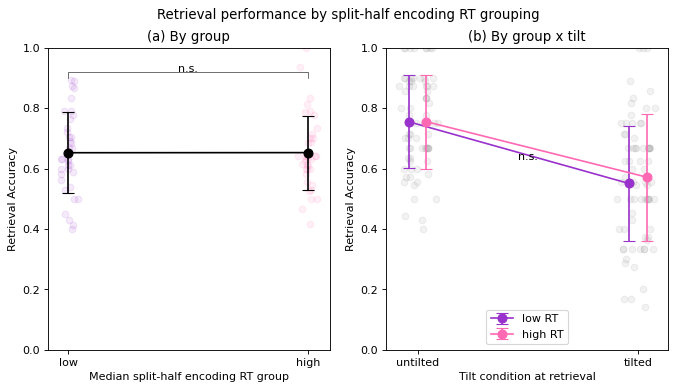

Test for panel A: 
 WilcoxonResult(statistic=309.0, pvalue=0.70613362503705)
Test for panel B: 
 $\beta = 0.02$, $F(3, 144)$ = $0.36, P = 0.722 $


In [135]:
fun.retrieval_split_plot(stats_enc_split)

so how do we account for the paradoxical findings in retrieval performance?

## Item-Level Analysis

We can obtain for each face 1) avg encoding accuracy (when this face is oddity), 2) avg encoding RT, and 3) avg retrieval accuracy, and relate these measures to each other, to the classification judgements, and to stimulus attributes

In [136]:
stats_byface = fun.get_stats_byface(df, only_correct_encoding = True)

In [137]:
stats_byface

,identity,race,gender,enc_rt,enc_acc,ret_rt,ret_acc,ret_rt_0,ret_acc_0,ret_rt_50,ret_acc_50,ret_dist,ret_dist_0,ret_dist_50,mb
0,152,white,woman,3664.5,0.642857,5265.00,0.777778,5265.00,0.800000,5329.60,0.750000,23.750000,19.750000,27.750000,0.835952
1,151,white,woman,2524.0,1.000000,4356.90,0.333333,3859.90,0.500000,4871.10,0.222222,55.066667,49.666667,58.666667,0.832355
2,146,white,man,2245.0,0.823529,3833.30,0.642857,3675.40,0.750000,3833.30,0.500000,43.307692,36.625000,54.000000,0.798890
3,143,white,man,2629.5,0.600000,3250.60,0.833333,2765.80,1.000000,3624.30,0.800000,33.500000,33.000000,33.600000,0.836225
4,122,black,man,2528.5,0.888889,3823.30,0.625000,4237.55,0.833333,3578.30,0.500000,46.333333,32.666667,55.444444,0.809313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,021,black,man,2812.0,0.833333,4141.60,0.800000,4020.40,1.000000,5286.70,0.500000,27.000000,18.000000,40.500000,0.821749
116,044,white,man,2920.0,0.777778,4383.80,0.428571,4383.80,0.600000,4489.65,0.000000,50.142857,38.000000,80.500000,0.824183
117,090,black,man,2559.0,0.818182,3936.30,0.666667,3809.70,0.800000,4215.15,0.500000,34.666667,20.400000,52.500000,0.820820
118,155,white,woman,2445.5,1.000000,4248.30,0.833333,4248.30,0.750000,3721.15,1.000000,33.833333,40.250000,21.000000,0.846185


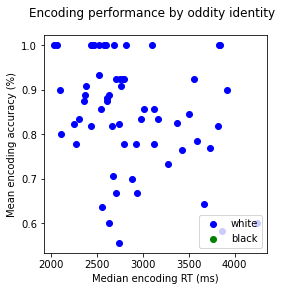

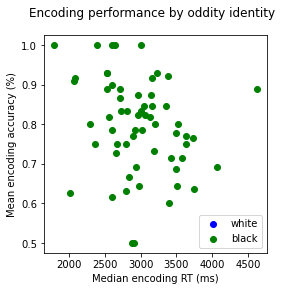

In [138]:
fun.encoding_byface_plot(stats_byface[stats_byface.race=='white'])
fun.encoding_byface_plot(stats_byface[stats_byface.race=='black'])
#fun.encoding_byface_plot(stats_byface)

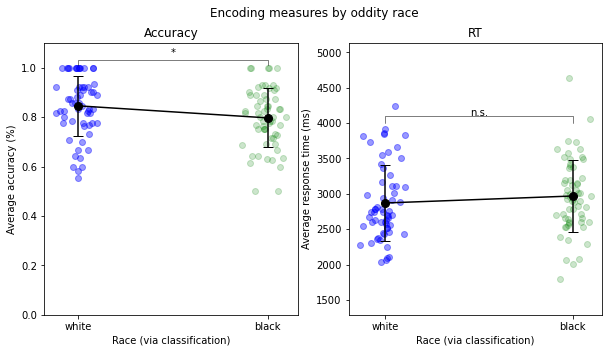

In [139]:
#fun.encoding_byface_plot(stats_byface)
fun.encoding_byface_group_plot(stats_byface)

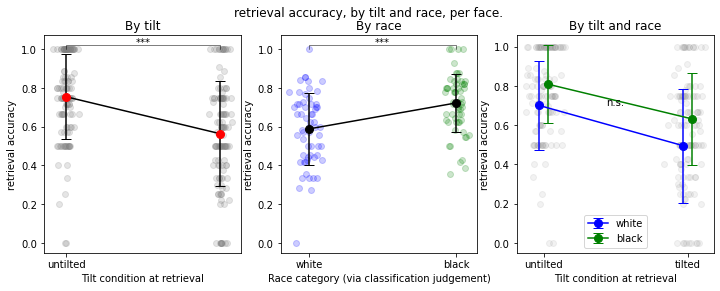

In [140]:
fun.retrieval_byface_plots(stats_byface)
#fun.retrieval_byface_plots(stats_byface, slider=True)

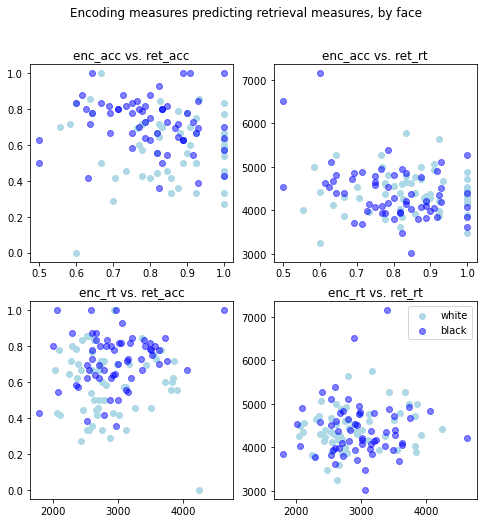

LinregressResult(slope=-6.505537813498908e-05, intercept=1.0113242000457963, rvalue=-0.276549705398601, pvalue=0.0022311363410004816, stderr=2.0810964841527283e-05, intercept_stderr=0.061736131532308794)
LinregressResult(slope=-0.25520446750712844, intercept=0.8649006697273568, rvalue=-0.17444916161560212, pvalue=0.056697981359419815, stderr=0.13260729157184134, intercept_stderr=0.1101208075188191)
LinregressResult(slope=-1023.713119208413, intercept=5254.4230634690375, rvalue=-0.21934307201559425, pvalue=0.016083194205382206, stderr=419.1856531212496, intercept_stderr=348.1035022648613)
LinregressResult(slope=2.7252703956395644e-05, intercept=0.5757029581633238, rvalue=0.07919179865757303, pvalue=0.3899136655207788, stderr=3.158073950145863e-05, intercept_stderr=0.09368487730367751)
LinregressResult(slope=0.1177036360416171, intercept=4069.867589560835, rvalue=0.10720758830508242, pvalue=0.24382866468401126, stderr=0.10048774972049493, intercept_stderr=298.0988618918314)


In [141]:
fun.encoding_retrieval_byface_plot(stats_byface)
#fun.encoding_retrieval_byface_plot(mb_resid)
print(sp.linregress(x=stats_byface.enc_rt, y=stats_byface.enc_acc))
print(sp.linregress(x=stats_byface.enc_acc, y=stats_byface.ret_acc))
print(sp.linregress(x=stats_byface.enc_acc, y=stats_byface.ret_rt))
print(sp.linregress(x=stats_byface.enc_rt, y=stats_byface.ret_acc))
print(sp.linregress(x=stats_byface.enc_rt, y=stats_byface.ret_rt))

In [142]:
# interaction between enc_acc and race on ret_acc
w = stats_byface[stats_byface.race=='white']
b = stats_byface[stats_byface.race=='black']
fun.show_model_parameters(smf.ols("ret_acc ~ enc_rt * race", data = {
    'ret_acc': np.concatenate([w.ret_acc, b.ret_acc]),
    'enc_rt': np.concatenate([w.enc_rt, b.enc_rt]),
    'race': np.concatenate([np.repeat(1, len(w)), np.repeat(0, len(b))])
    }))

$\beta = -0.00$, $F(3, 116)$ = $-1.73, P = 0.087 $

### Stimulus attributes

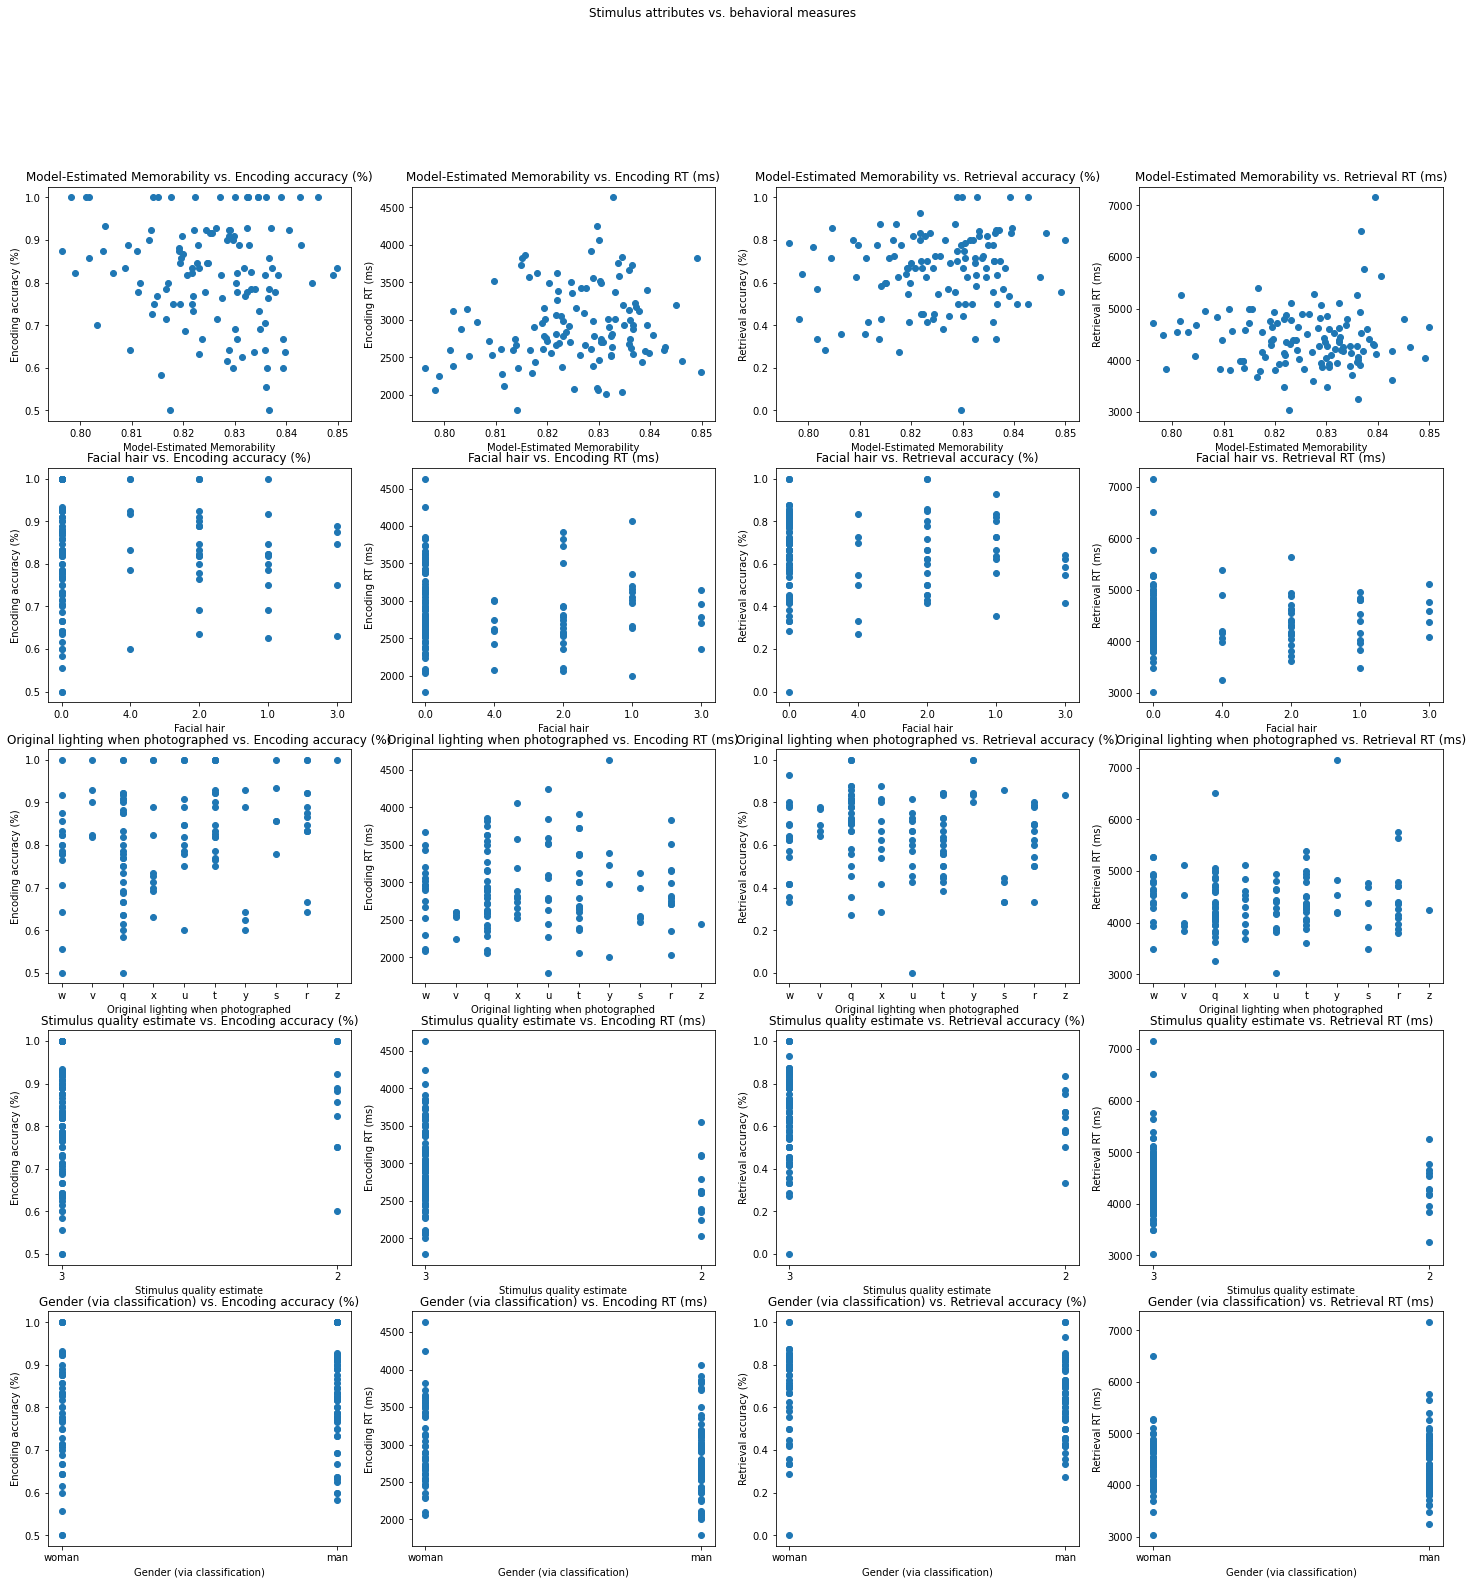

In [143]:
fun.stim_attributes_plot(stats_byface, meta)

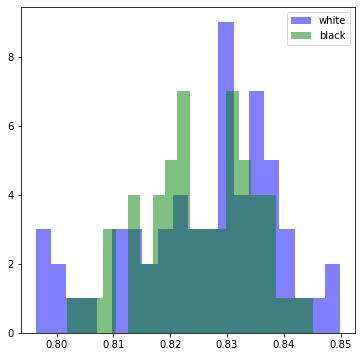

In [144]:
# memorability scores as a function of race
fun.mb_race_plot(meta)

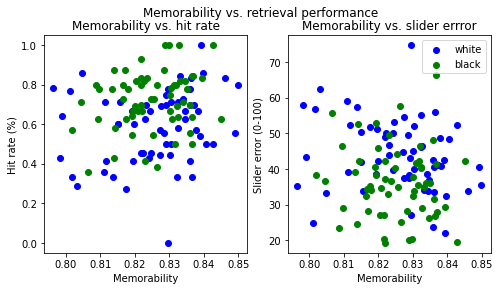

In [145]:
# memorability by race and retrieval accuracy 
# add per image memorability
fun.mb_race_acc_plot(stats_byface, meta)

### Residuals of memorability

In [146]:
mb_resid = stats_byface.copy()
print('R-squared values')
for col in mb_resid.columns:
    if col not in ['identity', 'race', 'gender']: 
        model = smf.ols("target ~ enc_rt", data = {
            "target": stats_byface[col],
            "enc_rt": stats_byface['enc_rt']
        }).fit()
        mb_resid[col] = model.resid
        print(col + ": " + str(model.rsquared))


R-squared values
enc_rt: 1.0
enc_acc: 0.07647973955605292
ret_rt: 0.01149346699019227
ret_acc: 0.006271340974621675
ret_rt_0: 0.001876501860062163
ret_acc_0: 8.298880660551067e-05
ret_rt_50: 0.0009004018170586381
ret_acc_50: 0.0034920176916712897
ret_dist: 0.0059983897760108595
ret_dist_0: 0.00047030062885478063
ret_dist_50: 0.00781433273785681
mb: 0.030529616580370234


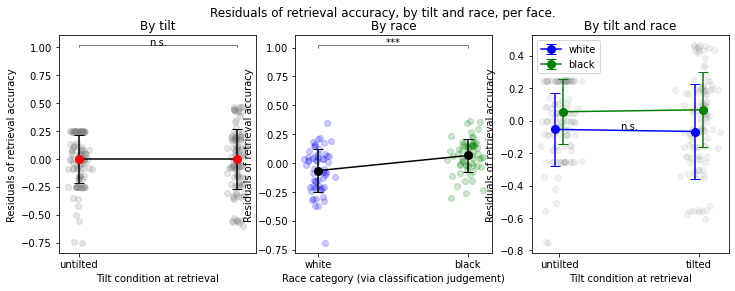

In [147]:
# ignore all but middle plot I think
fun.retrieval_byface_plots(mb_resid, slider = False, mb=True)

In [148]:
fun.ret_tests_byface(mb_resid)

Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=-4.282137480499837, pvalue=3.79138095571606e-05)
$\beta = -0.03$, $F(3, 235)$ = $-0.40, P = 0.687 $


In [149]:
enc_mb_resid = stats_byface.copy()
for col in enc_mb_resid.columns:
    if col not in ['identity', 'race', 'gender']: 
        model = smf.ols("target ~ enc_rt * enc_acc * mb", data = {
            "target": stats_byface[col],
            "enc_rt": stats_byface['enc_rt'],
            "enc_acc": stats_byface['enc_acc'],
            "mb": stats_byface['mb']
        }).fit()
        enc_mb_resid[col] = model.resid
        # print(col + ": " + str(model.rsquared))

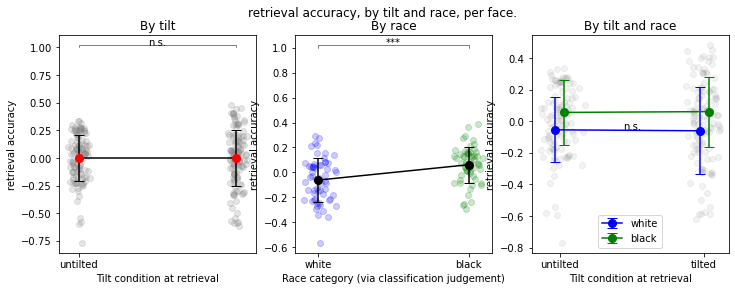

In [150]:
fun.retrieval_byface_plots(enc_mb_resid, slider = False)

In [151]:
fun.ret_tests_byface(enc_mb_resid)

Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=-4.204983673342494, pvalue=5.108797042629397e-05)
$\beta = -0.01$, $F(3, 235)$ = $-0.19, P = 0.851 $


### Split half reliability analyses

In [152]:
# of faces, of images, of races, of race-by-tilt (all resolutions)

## New comparisons

### 1. Within-group AFC vs. across-group AFC

In [153]:
# afc_ref = {
#     "pilot_sona_afc2": "across",
#     "pilot_prolific_afc2": "across",
#     "prolific_afc_50_subjects": "across",
    
#     "sona_afc3": "within",
#     "pilot_prolific_afc": "within",
#     "prolific_afc3": "within"
# }
# stats['afc_type'] = [afc_ref[i] for i in stats.iteration]

In [154]:
# wa_data = {
#     'within_white': stats[(stats.afc_type == 'within') & (stats.race.str.contains('White'))],
#     'within_black': stats[(stats.afc_type == 'within') & (stats.race.str.contains('Black'))],
#     'across_white': stats[(stats.afc_type == 'across') & (stats.race.str.contains('White'))],
#     'across_black': stats[(stats.afc_type == 'across') & (stats.race.str.contains('Black'))]
# }
# fun.compare_versions(wa_data)

### 1.5. Pilot_prolific_afc only had 36 trials - does retrieval performance differ?

ValueError: The exact distribution of the Wilcoxon test statistic is not implemented for n=0

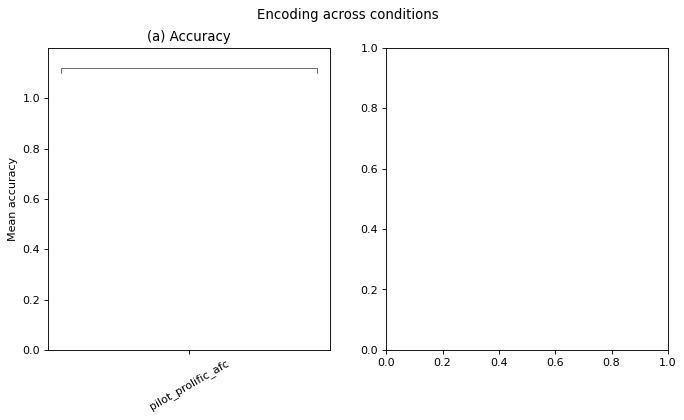

In [155]:
data_help = {
    'pilot_prolific_afc': stats[stats.iteration == 'pilot_prolific_afc'],
    'other': stats[stats.iteration != 'pilot_prolific_afc']
}
fun.compare_versions(data_help)

takeaway: not outside of distribution. if/when it gets to within-subject trial by trial analysis, this may matter more

### 2. White vs. black subs

In [156]:
stats[(stats.afc_type == 'within') & (stats.race.str.contains('White'))]
data_wb = {
    'white': stats[(stats.afc_type == 'within') & (stats.race.str.contains('White'))],
    'black': stats[(stats.afc_type == 'within') & (stats.race.str.contains('Black'))]
}
fun.compare_versions(data_wb)

AttributeError: 'DataFrame' object has no attribute 'afc_type'

takeaway: need to do models with interaction of subj reported race instead of this. but story is less clear than it looked before

### 3. Effect of age

In [157]:
stats['age'] = [df[(df.experiment_id == i) & (df.trial_type == 'demographics')].age.iloc[0] 
                for i in df.experiment_id.unique()]

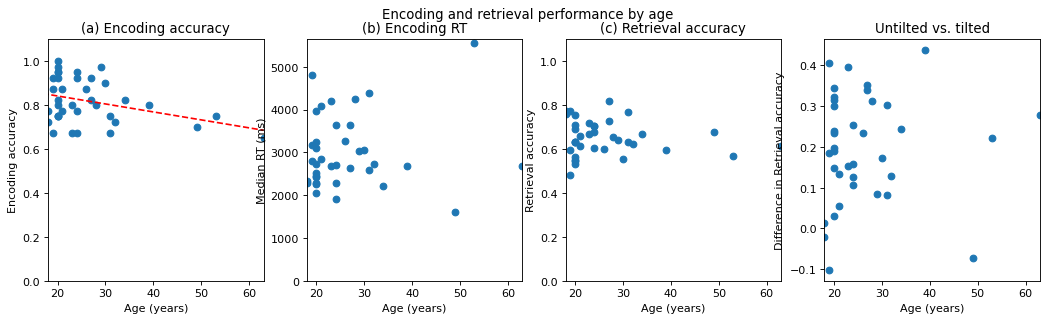

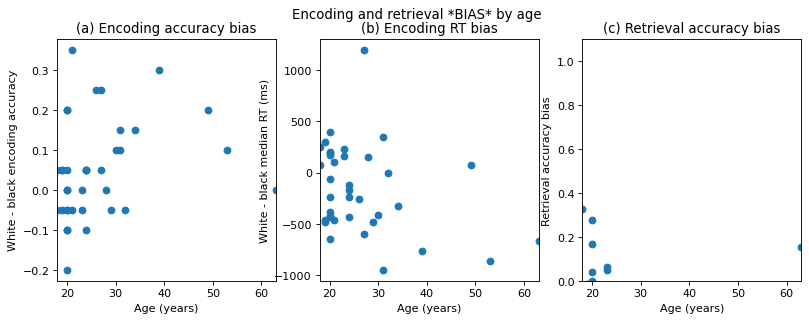

In [158]:
fun.age_plot(stats)
fun.age_bias_plot(stats)

takeaway: no noticeable effect of age here, most importantly on retrieval accuracy. Seems to be some effect on encoding RT but probably not huge or that important?

### 4. Prolific vs. sona

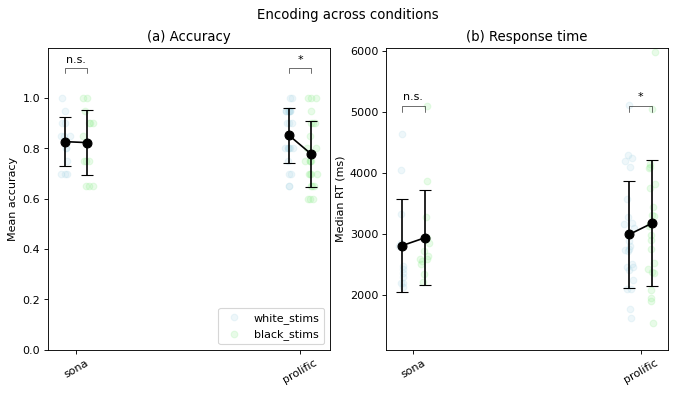

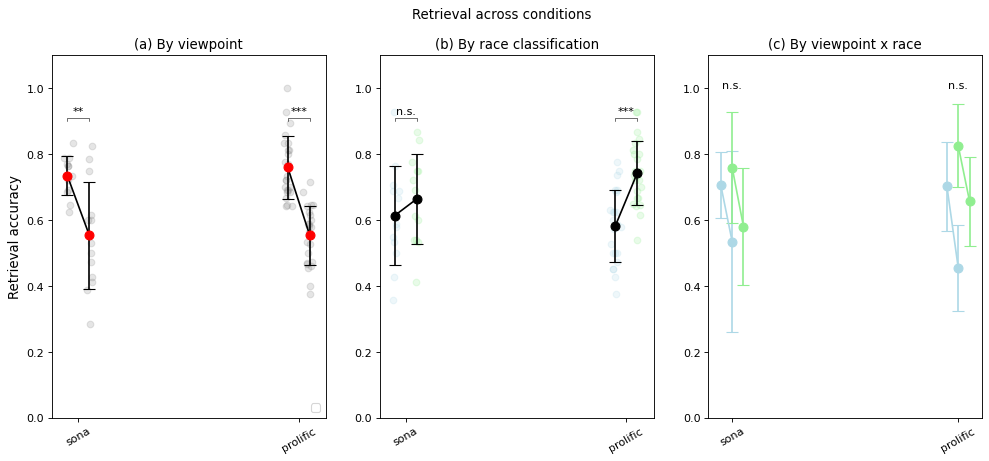

In [159]:
data_help = {
    'sona': stats[stats.iteration.str.contains('sona')],
    'prolific': stats[stats.iteration.str.contains('prolific')]
}
fun.compare_versions(data_help)

takeaway: no evident difference here

### 5. Different encoding splits (median, k=2 clustering etc) on memory performance (instead of subj race)